# Autoencoders

## Шаг 1
В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Вам нужно скачать оттуда lfw-deepfunneled.tgz и lfw_attributes.txt. Архив .tgz нужно распаковать =) После этого у вас появится папка с папками с лицами людей.

P.S. Не забудьте разбить выборку на train и test (нет, не в отдельные папки, а при загрузке в память компьютера в ноутбуке =))

P.P.S. для улучшения обучения автоэекодера полезно перевести величины пикселей картинки в отрезок [0, 1] (изначально они в интервале [0, 255]), а также привести их к типу float. Также удобно для начала сделать resize картинок в размер ~ (45, 45), чтобы обучить автоэнкодер было проще. Потом вы можете увеличить картинки как хотите, и усложнять вместе с ними автоэнкодер.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
zip_path = '/content/gdrive/My Drive/Colab Notebooks/final/lfw.tgz'
data_path = '/content/gdrive/My Drive/Colab Notebooks/final/'

In [0]:
import urllib.request
import tarfile

print('Downloading dataset ...')

url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'  
urllib.request.urlretrieve(url, zip_path)  

print('Dataset downloaded!')

tar = tarfile.open(zip_path, "r:gz")
tar.extractall(data_path)
tar.close()
print('Dataset uzipped!')

## Шаг 2

Пока скачивается датасет, можно набросать план действий:

Разботать и реализовать автоэнкодер. Обычный (как на картинке)
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Вектор в середине (выход ancoder'а) называется латентным вектором/представлением картинки.

Для начала стоит почитать статьи/посты про автоэнкодеры. Автоэнкодер будет представлять собой класс-наследник nn.Module (как и обычно). Параметры типа кол-ва слоев, кол-ва нейронов в каждом слое и прочие советую вынести в отдельные переменные, чтобы потом было проще менять (вряд ли вы сразу угадаете, сколько слоев/нейронов вам нужно). Ну и, собственно, натренировать автоэекодер =) 

В процессе тренировки автоэекодера полезно следить не только за лоссом, но и за тем, как автоэнкодер восстанавливает каринки. Не поленитесь и напишите код, который каждую эпоху (например) будет прогонять через автоэнкодер несколько картинок из val выборки и выводить на экран полученные реконструкции.

P.S. какой будет структура автоэнкодера -- свертки, только fully-connected -- решать Вам. Можно заставить работать и так, и так. Эксперементируйте =) 

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import pickle
import random
from torch import nn
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.utils import save_image

In [0]:
class Faces(Dataset):
    def __init__(self, root_dir=data_path, transform=None, dumped_dataset_path=None):
        self.root_dir = root_dir
        
        if transform is not None:
          self.transform = transform
        else:
          self.transform = transforms.Compose([
              transforms.Resize((125, 125)),
              transforms.RandomChoice([
              transforms.RandomRotation(10),
              transforms.RandomAffine(10),
              transforms.RandomHorizontalFlip(),
              transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
              ]),
              transforms.ToTensor(), ])
          
        if dumped_dataset_path is None:
          self.dataset = [] 

          i = 0
          for filename in os.listdir(self.root_dir  + 'lfw'):
            for image in os.listdir(self.root_dir + 'lfw/' + filename + '/'):
              i += 1
              if i % 100 == 0: 
                print(i, self.root_dir + 'lfw/' + filename + '/' + image)

              img = Image.open(self.root_dir + 'lfw/' + filename + '/' + image)
              if self.transform:
                img = self.transform(img)
              self.dataset.append(img)
        else:
          with open(dumped_dataset_path, "rb") as data:
            self.dataset = pickle.load(data)
            
        self.X_train = self.dataset[:int(len(self.dataset)*0.9)]
        self.X_test = self.dataset[int(len(self.dataset)*0.9):]

    def __len__(self):
        return len(self.X_train)
    def __getitem__(self, idx):
        return  self.X_train[idx]

In [0]:
face_dataset = Faces(dumped_dataset_path=data_path + "faces.bin")

In [0]:
# import pickle

# with open(data_path + "faces.bin", "wb") as output:
#     pickle.dump(face_dataset.dataset, output)
    
# with open(data_path + "faces.bin", "rb") as data:
#     face_dataset.dataset = pickle.load(data)

11909
[2859, 1748, 11151, 5009]
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])


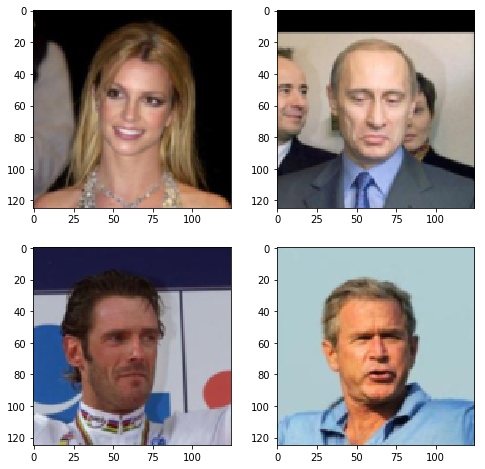

In [6]:
from random import randint

print(len(face_dataset))
x = [randint(0, len(face_dataset) - 1) for p in range(0, 4)]
print(x)

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows + 1):
  fig.add_subplot(rows, columns, i)
  print(face_dataset[x[i-1]].permute(1, 2, 0).shape)
  plt.imshow(face_dataset[x[i-1]].permute(1, 2, 0))
plt.show()

In [0]:
# hyperparameters
learning_rate = 1e-5
batch_size=128
num_epochs = 1000

In [0]:
img_height = 125
img_length = 125
  
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(img_length * img_height * 3, 1024)
        self.fc21 = nn.Linear(1024, 128)
        self.fc22 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1024)
        self.fc4 = nn.Linear(1024, img_length * img_height * 3)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        z = self.reparametrize(mu, logvar)
        
        return mu, logvar, z

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar, z = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [10]:
reconstruction_function = nn.MSELoss(size_average=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

In [0]:
model = VAE().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [0]:
dataloader = DataLoader(face_dataset, batch_size=batch_size, shuffle=True)

In [0]:
def to_img(x):
  x = x.clamp(0, 1)
  x = x.view(3, img_height, img_length)
  return x

In [15]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, img in enumerate(dataloader):
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # forward
        optimizer.zero_grad()
        reconstruction, mu, logvar, z = model(img)
       
        loss = loss_function(reconstruction, img, mu, logvar)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if batch_idx  % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,
              batch_idx * len(img),
              len(dataloader.dataset), 100. * batch_idx / len(dataloader),
              loss.data[0] / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(reconstruction[0].cpu().data)
        save_image(save, data_path + '/generated/vae/' + 'image_{}.png'.format(epoch))
      
torch.save(model.state_dict(), data_path + './vae.pth')



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


====> Epoch: 0 Average loss: 4055.5309
====> Epoch: 1 Average loss: 3215.3232
====> Epoch: 2 Average loss: 2919.6842
====> Epoch: 3 Average loss: 2724.4590
====> Epoch: 4 Average loss: 2589.0572
====> Epoch: 5 Average loss: 2483.9396
====> Epoch: 6 Average loss: 2381.3657
====> Epoch: 7 Average loss: 2273.5109
====> Epoch: 8 Average loss: 2179.6266
====> Epoch: 9 Average loss: 2099.0161
====> Epoch: 10 Average loss: 2033.7142
====> Epoch: 11 Average loss: 1975.7849
====> Epoch: 12 Average loss: 1924.7978
====> Epoch: 13 Average loss: 1880.7500
====> Epoch: 14 Average loss: 1838.4106
====> Epoch: 15 Average loss: 1799.8834
====> Epoch: 16 Average loss: 1767.7753
====> Epoch: 17 Average loss: 1731.0605
====> Epoch: 18 Average loss: 1699.7648
====> Epoch: 19 Average loss: 1675.5372
====> Epoch: 20 Average loss: 1649.2414
====> Epoch: 21 Average loss: 1627.8290
====> Epoch: 22 Average loss: 1606.5131
====> Epoch: 23 Average loss: 1587.7463
====> Epoch: 24 Average loss: 1570.4058
====> Epoc

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


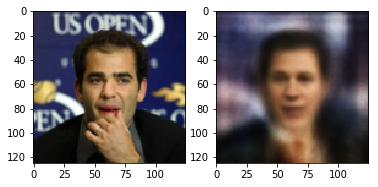

In [16]:
# from train set
for img in dataloader:
  img = img.view(img.size(0), -1)
  img = Variable(img).cuda()
  reconstructed, _, _, _ = model(img)
  break

_, axarr = plt.subplots(1,2)
axarr[0].imshow((img.cpu()[0]).view(3, img_height, img_length).permute(1, 2, 0))
axarr[1].imshow(to_img(reconstructed[0].cpu().data).permute(1, 2, 0))

1324
379
torch.Size([1, 46875])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


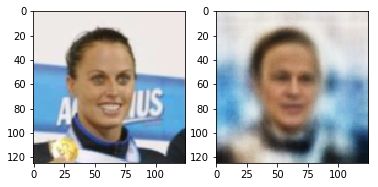

In [17]:
# from test set
print(len(face_dataset.X_test))
rand_idx = randint(0, len(face_dataset.X_test) - 1)
print(rand_idx)

img = face_dataset.X_test[rand_idx].view(1,-1)
img = Variable(img).cuda()
print(img.shape)
reconstructed, _, _, _ = model(img)

_, axarr = plt.subplots(1,2)
axarr[0].imshow((img.cpu()[0]).view(3, img_height, img_length).permute(1, 2, 0))
axarr[1].imshow(to_img(reconstructed[0].cpu().data).permute(1, 2, 0))

torch.Size([46875])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


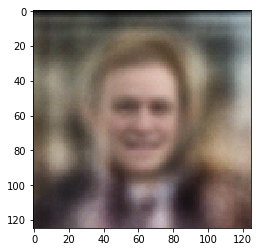

In [44]:
# generate random face

latent_code = np.random.randn(128)
latent_code = F.relu(Variable(torch.from_numpy(latent_code).float()).cuda())
generated = model.decode(latent_code)

print(generated.shape)
plt.imshow(to_img(generated.cpu().data).permute(1, 2, 0))

Лепим улыбку

In [0]:
transform = transforms.Compose([
              transforms.Resize((125, 125)),
              transforms.ToTensor(), ])

In [0]:
happy_dataset = [] 

for image in os.listdir(data_path  + 'happy'):
  img = Image.open(data_path + 'happy' + '/' + image)
  img = transform(img)
  happy_dataset.append(img)

In [0]:
unhappy_dataset = [] 

for image in os.listdir(data_path  + 'unhappy'):
  img = Image.open(data_path + 'unhappy' + '/' + image)
  img = transform(img)
  unhappy_dataset.append(img)

16 16


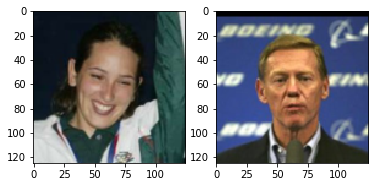

In [58]:
random_index = random.randint(0, len(happy_dataset)-1)

print(len(happy_dataset), len(unhappy_dataset))
_, axarr = plt.subplots(1,2)
axarr[0].imshow(happy_dataset[random_index].permute(1, 2, 0))
axarr[1].imshow(unhappy_dataset[random_index].permute(1, 2, 0))

In [59]:
mean_latent_code_happy = 0
mean_latent_code_unhappy = 0

for img_happy, img_unhappy in zip(happy_dataset,unhappy_dataset):
  img_happy = img_happy.view(1, -1)
  img_unhappy = img_unhappy.view(1, -1)
  
  img_happy = Variable(img_happy).cuda()
  img_unhappy = Variable(img_unhappy).cuda()

  reconstruction_happy, _, _, latent_code_happy = model(img_happy)
  mean_latent_code_happy += latent_code_happy/16
#  latent_codes_happy.append(latent_code_happy)
  
  reconstruction_unhappy, _, _, latent_code_unhappy = model(img_unhappy)
  mean_latent_code_unhappy += latent_code_unhappy/16
#  latent_codes_unhappy.append(latent_code_unhappy)
  
#print(mean_latent_code_happy, mean_latent_code_unhappy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


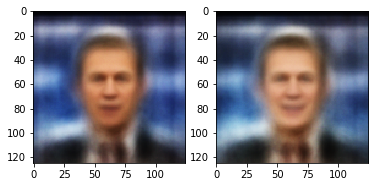

In [60]:
diff_vector = mean_latent_code_happy - mean_latent_code_unhappy

img_unhappy = unhappy_dataset[random_index]
img_unhappy = img_unhappy.view(1, -1)
img_unhappy = Variable(img_unhappy).cuda()

reconstruction_unhappy, _, _, latent_code_unhappy = model(img_unhappy)

add_smile = latent_code_unhappy + diff_vector
simely = model.decode(add_smile)

_, axarr = plt.subplots(1,2)
axarr[0].imshow(to_img(reconstruction_unhappy.cpu().data).permute(1, 2, 0))
axarr[1].imshow(to_img(simely.cpu().data).permute(1, 2, 0))

## Шаг 3

Если вы смогли подобрать параметры сети и обучить ее, то пора начать играться =)

Играться можно так:

а) сгенерировать рандомные латентные векторы (без энкодера, например, с помощью np.random.randn), скормить их decoder'у и посмотреть, что получится. То есть, вы сможете создавать новые лица людей из векторов

б) Второе, что предлагается сделать -- научить лепить улыбки на лица грустных людей.

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# BONUS 1. 
### Variational Autoencoder

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

В этом бонусе предлагается научиться реализовывать Variational autoencoders. После этого с ним можно точно так же играться -- генерить новых людей (кстати, сравните с тем, как генерит обычный автоэнкодер -- кто круче и почему?) пририсовывать улыбки тем же самым способом, что и для обычного autoencoder. Вперед!